In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import warnings
import mlflow

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error

# Set database for mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
# Set experiment.
mlflow.set_experiment('nyc-taxi-experiment')
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_parquet('../data/yellow_tripdata_2022-01.parquet')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [5]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda duration: duration.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [6]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df.duration.values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

7.0014961794378525

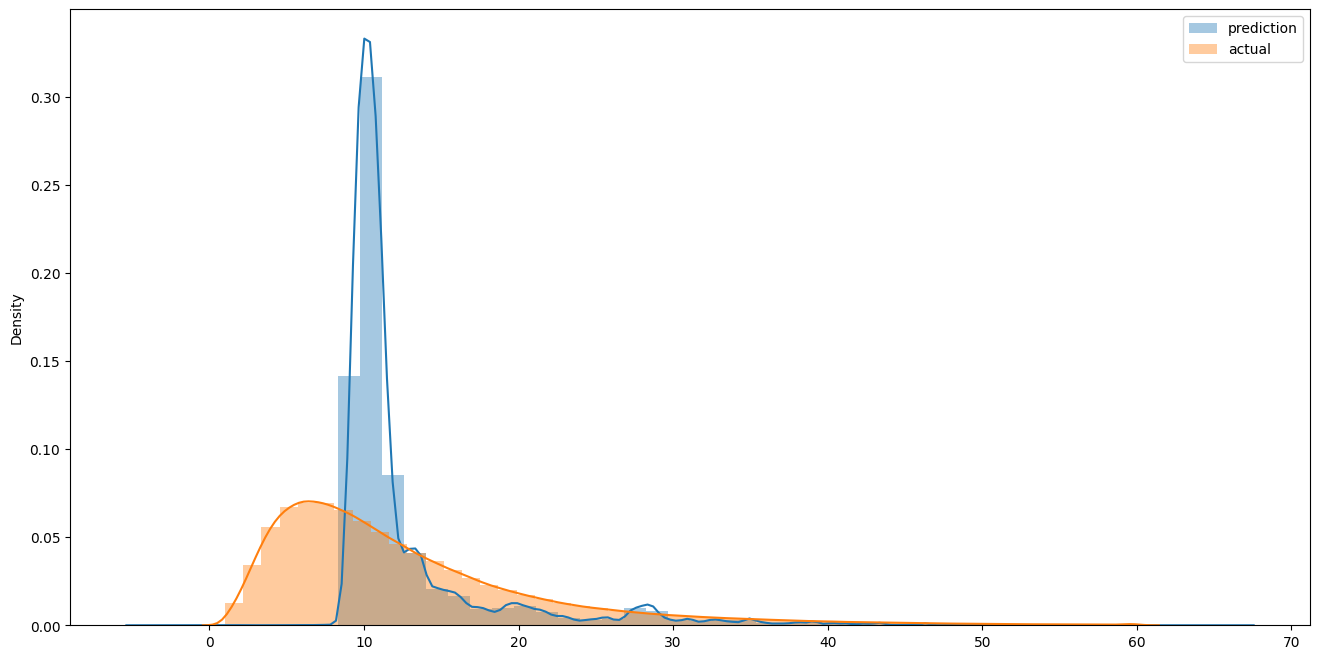

In [7]:
plt.figure(figsize=(16,8))
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')
plt.legend()
plt.show()

In [8]:
def read_dataframe(filename: str) -> pd.DataFrame:
    
    df = pd.read_parquet(filename)
    
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda duration: duration.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']

    df[categorical] = df[categorical].astype(str)

    return df

In [9]:
df_train = read_dataframe('../data/yellow_tripdata_2022-01.parquet')
df_val = read_dataframe('../data/yellow_tripdata_2022-02.parquet')

In [10]:
len(df_train), len(df_val)

(2421440, 2918187)

In [11]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [12]:
categorical = ['PU_DO']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [13]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.530086925753844

In [15]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [15]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

9.374921127169834

In [18]:
# Using mlflow to track the experiments
with mlflow.start_run():
    # Set a tag for experiment.
    mlflow.set_tag("developer", "marcospereira")

    # Log parameters, like hyperparameters for a model or other info that you considering important
    # for the experiment
    mlflow.log_param('train-data-path', '../data/yellow_tripdata_2022-01.parquet')
    mlflow.log_param('valid-data-path', '../data/yellow_tripdata_2022-02.parquet')

    # Hypeparameters
    alpha = 0.1
    mlflow.log_param('alpha', alpha)

    lr = Lasso(alpha=alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)

    mlflow.log_metric('rmse', rmse)

In [16]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [17]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, y_val)

In [27]:
def objective(params):
    
    with mlflow.start_run():
        mlflow.set_tag('model', 'xgboost')
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=500,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )

        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric('rmse', rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [28]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42,
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[17:25:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:14.75314                          
[1]	validation-rmse:13.30842                          
[2]	validation-rmse:12.06202                          
[3]	validation-rmse:10.99009                          
[4]	validation-rmse:10.06996                          
[5]	validation-rmse:9.28475                           
[6]	validation-rmse:8.61675                           
[7]	validation-rmse:8.05091                           
[8]	validation-rmse:7.57222                           
[9]	validation-rmse:7.16987                           
[10]	validation-rmse:6.83218                          
[11]	validation-rmse:6.54908                          
[12]	validation-rmse:6.31274                          
[13]	validation-rmse:6.11479                          

KeyboardInterrupt: 

In [18]:
# Get best parameters and train
params = {
    'learning_rate': 0.052171063680732786,
    'max_depth': 43,
    'min_child_weight': 3.873525382081908,
    'objective': 'reg:linear',
    'reg_alpha': 0.02908096307849183,
    'reg_lambda': 0.005592226647424518,
    'seed': 42,
}


In [19]:
# We can use auto log for xgoost
mlflow.xgboost.autolog()
booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=500,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )


2023/05/24 10:11:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3ce2b8ac0d814611afc2dcb3de7f86b4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[10:11:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:15.71166
[1]	validation-rmse:15.04076
[2]	validation-rmse:14.40821
[3]	validation-rmse:13.81214
[4]	validation-rmse:13.25055
[5]	validation-rmse:12.72171
[6]	validation-rmse:12.22416
[7]	validation-rmse:11.75603
[8]	validation-rmse:11.31604
[9]	validation-rmse:10.90267
[10]	validation-rmse:10.51444
[11]	validation-rmse:10.15014
[12]	validation-rmse:9.80837
[13]	validation-rmse:9.48805
[14]	validation-rmse:9.18805
[15]	validation-rmse:8.90737
[16]	validation-rmse:8.64466
[17]	validation-rmse:8.39901
[18]	validation-rmse:8.16961
[19]	validation-rmse:7.95533
[20]	validation-rmse:7.75533
[21]	validation-rmse:7.56919
[22]	validation-rmse:7.39547
[23]	validation-rmse:7.23324
[24]	validation-rmse:7.08276
[25]	validation-rmse:6.94235
[26]	validati

2023/05/24 10:57:52 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.


In [20]:
# LOG model into mlflow
# In this way you need to export the model using picle first to indicate the local_path
with mlflow.start_run():
    # Set a tag for experiment.
    mlflow.set_tag("model", "lasso-log-model")

    # Log parameters, like hyperparameters for a model or other info that you considering important
    # for the experiment
    mlflow.log_param('train-data-path', '../data/yellow_tripdata_2022-01.parquet')
    mlflow.log_param('valid-data-path', '../data/yellow_tripdata_2022-02.parquet')

    # Hypeparameters
    alpha = 0.1
    mlflow.log_param('alpha', alpha)

    lr = Lasso(alpha=alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)

    mlflow.log_metric('rmse', rmse)
    
    mlflow.log_artifact(local_path='../models/lin_reg.bin', artifact_path='models_pickle')

In [24]:
mlflow.xgboost.autolog(disable=True)

# Another way to export a model. No needed to export with pickle before.
with mlflow.start_run():

    train = xgb.DMatrix(X_train, y_train)
    valid = xgb.DMatrix(X_val, y_val)


    best_params = {
        'learning_rate': 0.052171063680732786,
        'max_depth': 43,
        'min_child_weight': 3.873525382081908,
        'objective': 'reg:linear',
        'reg_alpha': 0.02908096307849183,
        'reg_lambda': 0.005592226647424518,
        'seed': 42,
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
                params=best_params,
                dtrain=train,
                num_boost_round=50,
                evals=[(valid, "validation")],
                early_stopping_rounds=5
            )
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('rmse', rmse)

    with open('models/preprocessor.b', 'wb') as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact('models/preprocessor.b', artifact_path='preprocessor')
    
    mlflow.xgboost.log_model(booster, artifact_path='models_mlflow')

[16:24:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:15.71166
[1]	validation-rmse:15.04076
[2]	validation-rmse:14.40821
[3]	validation-rmse:13.81214
[4]	validation-rmse:13.25055
[5]	validation-rmse:12.72171
[6]	validation-rmse:12.22416
[7]	validation-rmse:11.75603
[8]	validation-rmse:11.31604
[9]	validation-rmse:10.90267
[10]	validation-rmse:10.51444
[11]	validation-rmse:10.15014
[12]	validation-rmse:9.80837
[13]	validation-rmse:9.48805
[14]	validation-rmse:9.18805
[15]	validation-rmse:8.90737
[16]	validation-rmse:8.64466
[17]	validation-rmse:8.39901
[18]	validation-rmse:8.16961
[19]	validation-rmse:7.95533
[20]	validation-rmse:7.75533
[21]	validation-rmse:7.56919
[22]	validation-rmse:7.39547
[23]	validation-rmse:7.23324
[24]	validation-rmse:7.08276
[25]	validation-rmse:6.94235
[26]	validati

In [25]:
# Load Model
logged_model = 'runs:/27c14687bceb401bad73fc5d2085d735/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

2023/05/24 16:42:35 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


[16:42:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [26]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 27c14687bceb401bad73fc5d2085d735

In [27]:
# load xgboost model
xgboost_model = mlflow.xgboost.load_model(logged_model)
xgboost_model

[16:44:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
